# Greenberger–Horne–Zeilinger (GHZ) State Fidelity

The aim of this benchmark is to show whether a GHZ state with high enough fidelity can be prepared such that the state is genuinely multipartite entangled. One can show that a fidelity larger than 0.5 is a sufficient condition (see Leibfried, D. et al., [Nature 438, 639–642](https://www.nature.com/articles/nature04251)  (2005))

The benchmark currently offers two methods to estimate the fidelity:
* Multiple quantum coherences (G. J. Mooney et al., [J. Phys. Commun. 5, 095004](https://iopscience.iop.org/article/10.1088/2399-6528/ac1df7) (2021))
* Randomized measurements (Elben, A. et al., [Phys. Rev. A 99, 052323](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.99.052323) (2019))

Additionally, for a given set of $n$ qubits, different circuits can be applied which lead to the same GHZ state. Currently there are the following implementations:
* "naive": The textbook ciruit of depth $n$, which starts from a Hadamard gate on one qubit and entangles each additional qubit with a CNOT operation from the first qubit.
* "log_depth": A logarithmic depth circuit utilizing parallel CNOT applications. Either the method in Cruz et al. [arXiv:1807.05572](https://arxiv.org/abs/1807.05572) or the method in Mooney et al. [arXiv:2101.08946](https://arxiv.org/abs/2101.08946) is used, depending on which yields the lower depth or the lower number of 2-qubit gates. 
* "star": A linear circuit that creates GHZ states that is tailored for IQM's novel, effectively all-to-all, connected QPU topology.
* "tree": An IQM-developed logarithmic depth circuit utilizing calibration data of the CZ average fidelities and a tree-graph algorithm to find a circuit with minimal depth and high fidelity 2-qubit gates. 

Note that the first two methods will always give, respectively, the same circuits for the same qubit layouts and same coupling maps, while the `tree` method relies on the latest calibration data and can give different circuits at different execution times. 
Thus, for consistent comparisons, one of the first two methods should be chosen, while for the best results, i.e., the largest possible Genuine Multipartite Entanglement (GME) - entangled GHZ state, the `tree`-method is preferable.

In [1]:
from iqm.benchmarks.entanglement.ghz import *
backend = "deneb"

## Set IQM Token if using Resonance.

In [2]:
import os
os.environ["IQM_TOKEN"] = ""

## Definition of the benchmark configuration
The important parameters are:
* ``custom_qubits_array``: A ``list[list[int]]`` which includes all qubit layouts on which the benchmark is run.
* ``shots``: The number of shots for the fidelity measurement
* ``fidelity_routine``: Either "coherences" or "randomized_measurements"
* ``rem``: Boolean value that controls whether readout error mitigation is used
* ``mit_shots``: Whenever rem=True, this parameter controls the total number of shots used to calibrate readout error mitgation
* ``num_RMs``: The number of randomized measurement settings (only necessary when choosing ``fidelity_routine=randomized_measurements``)

In [3]:
num_qubits = 7
MINIMAL_GHZ = GHZConfiguration(
    state_generation_routine="star",
            custom_qubits_array=[
            list(range(1,x+1)) for x in range(2,num_qubits) ## layout of qubits to run the benchmark on
            ],
    shots=1000,
    fidelity_routine="coherences",  ## use multiple coherence method 
    rem=True,
    mit_shots=1000,
)

## Running the benchmark

In [4]:
benchmark_ghz = GHZBenchmark(backend, MINIMAL_GHZ)
run_ghz = benchmark_ghz.run()

2025-02-07 17:28:05,978 - iqm.benchmarks.logging_config - INFO - Now generating a 2-qubit GHZ state on qubits [1, 2]
2025-02-07 17:28:05,980 - iqm.benchmarks.logging_config - INFO - Transpiling for backend IQM Backend with optimization level 3, sabre routing method and SQG optimization all circuits
2025-02-07 17:28:06,304 - iqm.benchmarks.logging_config - INFO - Transpiling for backend IQM Backend with optimization level 3, sabre routing method and SQG optimization all circuits
2025-02-07 17:28:06,371 - iqm.benchmarks.logging_config - INFO - Submitting batch with 7 circuits corresponding to qubits [1, 2]
/opt/anaconda3/envs/iqm-benchmarks/lib/python3.11/site-packages/iqm/qiskit_iqm/iqm_provider.py:170: UserWarning: Unknown backend option(s): {'calibration_set_id'}
  warnings.warn(f'Unknown backend option(s): {unknown_options}')
2025-02-07 17:28:07,038 - iqm.benchmarks.logging_config - INFO - Now generating a 3-qubit GHZ state on qubits [1, 2, 3]
2025-02-07 17:28:07,040 - iqm.benchmarks

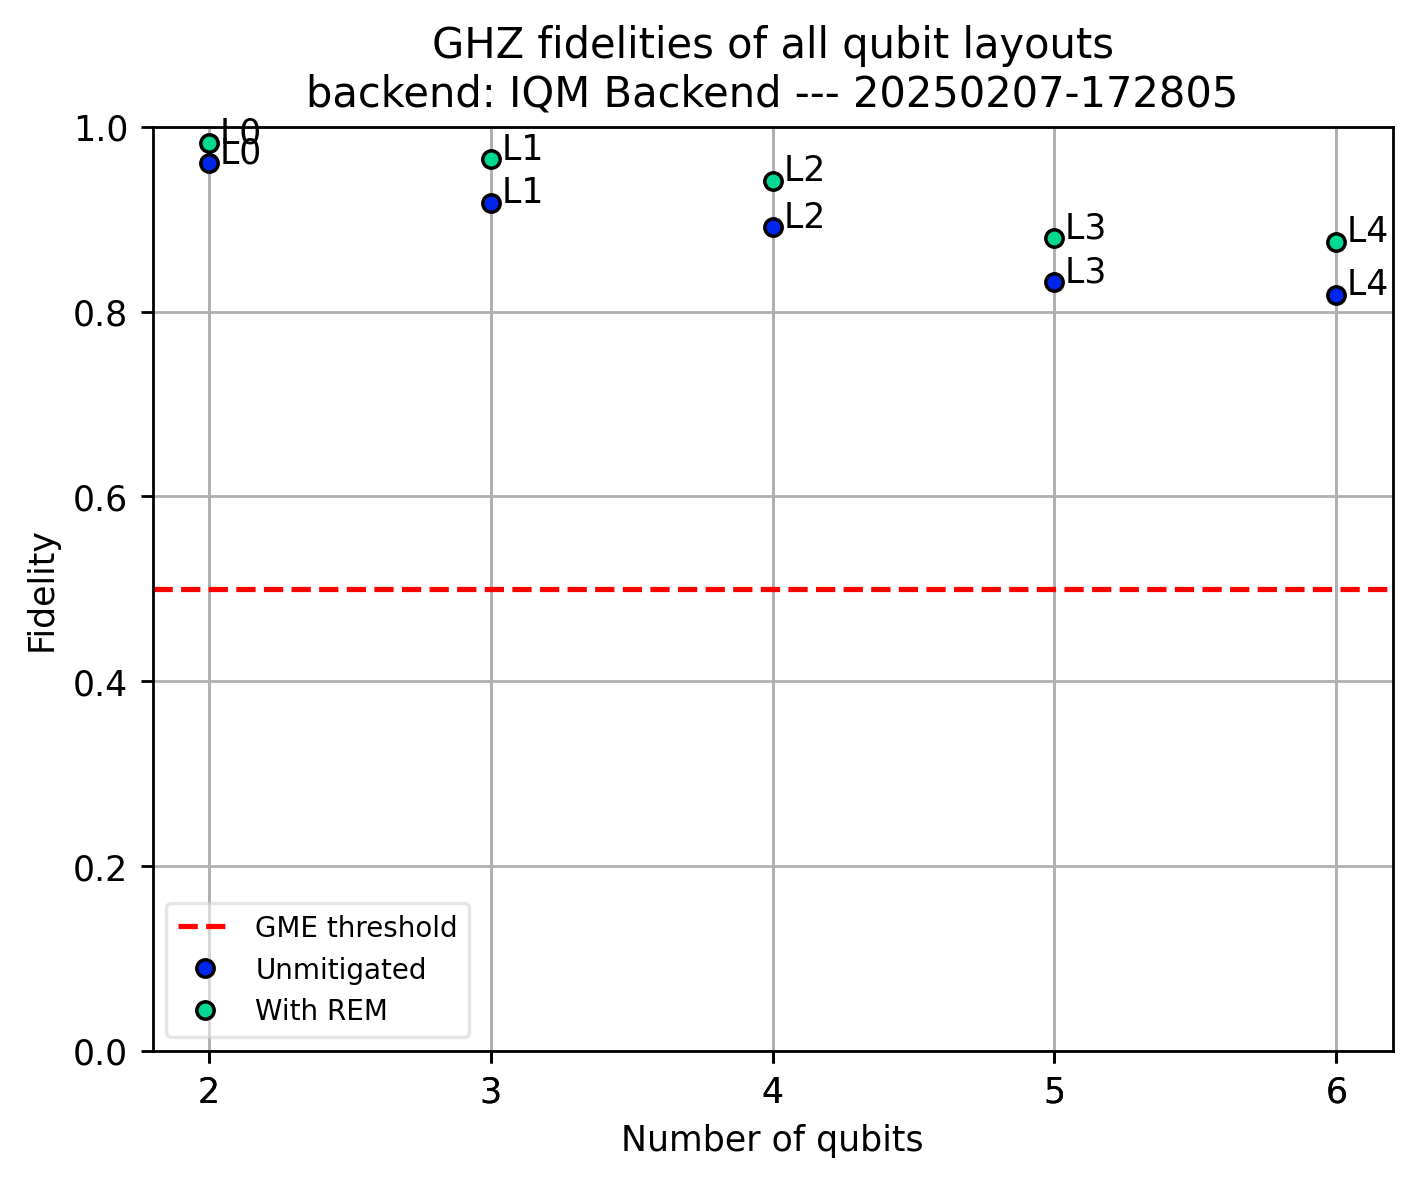

In [5]:
result = benchmark_ghz.analyze()
result.plot_all()

## Accessing the results
To see individual fidelitiy and uncertainty values of a given qubit layout, one can filter the ``result.observations``-list by layout as shown below. 

The plot allows a comparison of all layout results with and without REM, where the data point description labels "L0", "L1", ... enumerate the layouts in the order defined in the configuration.

In [11]:
result.observations

[BenchmarkObservation(name='fidelity', value=0.9613380512562306, identifier=BenchmarkObservationIdentifier(qubit_indices=[1, 2]), uncertainty=None),
 BenchmarkObservation(name='fidelity_rem', value=0.9821213555841487, identifier=BenchmarkObservationIdentifier(qubit_indices=[1, 2]), uncertainty=None),
 BenchmarkObservation(name='fidelity', value=0.9178722518157161, identifier=BenchmarkObservationIdentifier(qubit_indices=[1, 2, 3]), uncertainty=None),
 BenchmarkObservation(name='fidelity_rem', value=0.9647158956901334, identifier=BenchmarkObservationIdentifier(qubit_indices=[1, 2, 3]), uncertainty=None),
 BenchmarkObservation(name='fidelity', value=0.891546563661733, identifier=BenchmarkObservationIdentifier(qubit_indices=[1, 2, 3, 4]), uncertainty=None),
 BenchmarkObservation(name='fidelity_rem', value=0.9418409220030468, identifier=BenchmarkObservationIdentifier(qubit_indices=[1, 2, 3, 4]), uncertainty=None),
 BenchmarkObservation(name='fidelity', value=0.8321815900322429, identifier=B

In [16]:
result.observations
Fid = [x.value for x in result.observations[::2]]
Fid_rem = [x.value for x in result.observations[1::2]]


In [17]:
## store data
import pickle
import os
from datetime import datetime

date_str = datetime.now().strftime("%Y-%m-%d")
save_dir = f"data_ghz_{date_str}"
os.makedirs(save_dir, exist_ok=True)

# Function to save a list as a pickle file
def save_pickle(data, filename):
    with open(filename, "wb") as f:
        pickle.dump(data, f)

# Save each list separately
save_pickle(Fid, os.path.join(save_dir, "fidelity.pkl"))
save_pickle(Fid_rem, os.path.join(save_dir, "fidelity_rem.pkl"))


print(f"Pickle files saved in {save_dir}")

[0.9821213555841487,
 0.9647158956901334,
 0.9418409220030468,
 0.8794115489042997,
 0.875606862035571]